In [1]:
import csv 
import networkx as nx
import matplotlib.pyplot as plt

from graph import Graph
from article import Article
import random
import pandas as pd
import seaborn as sns
import mplcursors 
import numpy as np

## Part 1 : Graphs Creation at the Article, Category and Topic Level.

### 1.1 : Initialise empty graphs

In [2]:
cs_graph = Graph()
truth_graph = Graph()

### 1.2 : Read categories.tsv file to initialise the Vertices. $\\\\$

Populate the graph with the vertcies of each level (Articles, Categories and Topic).

In [3]:
cs_graph.update_graph("data/categories.tsv", mode='Initialization', verbose=True)
truth_graph.update_graph("data/categories.tsv", mode='Initialization', verbose=False)

The graph has 4599 articles, 127 categories, and 15 topics.
The number of edges is :
0 in the articles graph,
0 in the categories graph,
0 in the topics graph.


### 1.3 : Read the paths_finished.tsv and paths_unfinished.tsv  to construct Edges in the Common Sence Graph $\\\\$

Populate the adjacency matrix with the edges for each of the 3 graphs.

In [4]:
cs_graph.update_graph("data/paths_finished.tsv", mode='common_sense_edges', verbose=True) 

The graph has 4599 articles, 127 categories, and 15 topics.
The number of edges is :
50354 in the articles graph,
6530 in the categories graph,
208 in the topics graph.


In [5]:
cs_graph.update_graph("data/paths_unfinished.tsv", mode='common_sense_edges', verbose=True)

The graph has 4599 articles, 127 categories, and 15 topics.
The number of edges is :
57572 in the articles graph,
6931 in the categories graph,
208 in the topics graph.


### 1.4 : Read the links.tsv file to construct Edges in the Truth Graph $\\\\$ 

In [6]:
truth_graph.update_graph("data/links.tsv", mode='g', verbose=True)

The graph has 4599 articles, 127 categories, and 15 topics.
The number of edges is :
119769 in the articles graph,
8593 in the categories graph,
210 in the topics graph.


## Part 2 : Data Frame Creation at the Article, Category and Topic Level.

| Column name          | Description                                                                                                                                                                                       |   
|----------------------|---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Topic           | The topic of the vertex (Not valid for the Topic df)                                                                                                                                    |
| Category            | The category of the vertex (Not valid for the Topic df nor the the Category Df)                                                                      |
| out_degree          | The number of different articles to which users went from this article      |
| in_degree          | The number of different articles from which users ended up in this article    |
| degree             | Sum of nb_unique_outgoing_edges and nb_unique_incoming_edges            |
| total_weight_out        | Sum of the weights of the outgoing edges     |
| total_weight_in        | Sum of the weights of the incoming edges      |
| total_weight        | Sum of the weights of the incoming and outgoing edges       |
| average_weight_out        | The average weight of an outgoing edge      |
| average_weight_in       | The average weight of an incoming edge     |
| average_weight       | The average weight of an incoming or outgoing edge      |
| nb_articles       |   The number of articles in the Vertex (Not valid for articles)    |
| nb_categories       | The number of categories contained in the Vertex (Not valid for Articles and Categories df)   |



In [7]:
def vertices_to_df(graph, level):
    assert level in graph.authorized_levels
    _, verteces = graph.levels_map[level]
    header =["Topic", "Category", "degree", "out_degree", "in_degree", "total_weight" ,"total_weight_out", "total_weight_in","average_weight_per_edge", "average_weight_out", "average_weight_in"]  
    if level == "categories":
        header.remove("Category")
        header.append("nb_articles")
    if level == "topics":
        header.remove("Topic")
        header.remove("Category")
        header.append("nb_categories")
        header.append("nb_articles")
    
    df = pd.DataFrame(columns=header)
    for vertex in verteces.values():
        nb_unique_outgoing_edges = vertex.get_nb_different_out_neighbours()
        nb_unique_incoming_edges = vertex.get_nb_different_in_neighbours()
        nb_unique_edges = nb_unique_outgoing_edges + nb_unique_incoming_edges
        
        if (nb_unique_edges != 0) :
            total_weight_out = vertex.get_total_out_weight()
            total_weight_in = vertex.get_total_in_weight()
            total_weight = total_weight_out + total_weight_in
            average_weight_out = round(total_weight_out/nb_unique_outgoing_edges, 2) if nb_unique_outgoing_edges != 0 else 0
            average_weight_in = round(total_weight_in/nb_unique_incoming_edges,2) if nb_unique_incoming_edges != 0 else 0
            average_weight_per_edge = round(total_weight/nb_unique_edges, 2)

            if level == "articles":
                df.loc[vertex.title] = [vertex.topic, vertex.category, nb_unique_edges, nb_unique_outgoing_edges, nb_unique_incoming_edges, total_weight, total_weight_out, total_weight_in, average_weight_per_edge, average_weight_out, average_weight_in]
                df["Topic"].astype("category")
                df["Category"].astype("category")
            elif level == "categories":
                df.loc[vertex.title]= [vertex.topic, nb_unique_edges, nb_unique_outgoing_edges, nb_unique_incoming_edges, total_weight, total_weight_out, total_weight_in, average_weight_per_edge, average_weight_out, average_weight_in, vertex.get_nb_different_articles()]
                df["Topic"].astype("category")
            else:
                df.loc[vertex.title]= [nb_unique_edges, nb_unique_outgoing_edges, nb_unique_incoming_edges, total_weight, total_weight_out, total_weight_in, average_weight_per_edge, average_weight_out, average_weight_in, vertex.get_nb_different_categories(), vertex.get_nb_different_articles()]
    return df

### 2.1 : Create the Data Frame for the Common Sense Graphs

In [8]:
df_articles_cs = vertices_to_df(cs_graph, level="articles")
df_categrories_cs = vertices_to_df(cs_graph, level="categories")
df_topics_cs = vertices_to_df(cs_graph, level="topics")

In [9]:
df_articles_cs.sort_values(by=["out_degree"], ascending=False).head(5)

,Topic,Category,degree,out_degree,in_degree,total_weight,total_weight_out,total_weight_in,average_weight_per_edge,average_weight_out,average_weight_in
United_States,Geography,North_American_Geography,1531,255,1276,23348,11557,11791,15.25,45.32,9.24
Africa,Geography,African_Geography,512,179,333,6677,3318,3359,13.04,18.54,10.09
United_Kingdom,Geography,Geography_of_Great_Britain,840,167,673,9819,4817,5002,11.69,28.84,7.43
England,Geography,Geography_of_Great_Britain,733,165,568,8140,3978,4162,11.11,24.11,7.33
Europe,Geography,European_Geography,847,147,700,10599,5285,5314,12.51,35.95,7.59


In [10]:
df_categrories_cs.sort_values(by=["out_degree"], ascending=False).head(5)

,Topic,degree,out_degree,in_degree,total_weight,total_weight_out,total_weight_in,average_weight_per_edge,average_weight_out,average_weight_in,nb_articles
General_history,History,214,106,108,2665,1235,1430,12.45,11.65,13.24,80
European_Countries,Geography,227,105,122,4393,1423,2970,19.35,13.55,24.34,56
North_American_Geography,Geography,225,102,123,4264,1448,2816,18.95,14.20,22.89,103
Countries,Countries,219,101,118,5734,2401,3333,26.18,23.77,28.25,229
Geography_of_Great_Britain,Geography,221,101,120,3325,1275,2050,15.05,12.62,17.08,124


In [11]:
df_topics_cs.sort_values(by=["out_degree"], ascending=False).head(5)

,degree,out_degree,in_degree,total_weight,total_weight_out,total_weight_in,average_weight_per_edge,average_weight_out,average_weight_in,nb_categories,nb_articles
History,28.0,14.0,14.0,7721.0,3827.0,3894.0,275.75,273.36,278.14,14.0,545.0
People,28.0,14.0,14.0,8691.0,5510.0,3181.0,310.39,393.57,227.21,20.0,708.0
Countries,28.0,14.0,14.0,5734.0,2401.0,3333.0,204.79,171.50,238.07,1.0,229.0
Geography,28.0,14.0,14.0,18549.0,7368.0,11181.0,662.46,526.29,798.64,21.0,1084.0
Business_Studies,28.0,14.0,14.0,1414.0,691.0,723.0,50.50,49.36,51.64,4.0,88.0


### 2.2 : Create the Data Frame for the Truth Graphs

In [12]:
df_articles_truth = vertices_to_df(truth_graph, level="articles")
df_categrories_truth = vertices_to_df(truth_graph, level="categories")
df_topics_truth = vertices_to_df(truth_graph, level="topics")

In [13]:
df_articles_truth.sort_values(by=["out_degree"], ascending=False).head(5)

,Topic,Category,degree,out_degree,in_degree,total_weight,total_weight_out,total_weight_in,average_weight_per_edge,average_weight_out,average_weight_in
United_States,Geography,North_American_Geography,1845,294,1551,1845,294,1551,1.0,1.0,1.0
Driving_on_the_left_or_right,Design_and_Technology,Road_transport,255,255,0,255,255,0,1.0,1.0,0.0
List_of_countries,Geography,General_Geography,307,244,63,307,244,63,1.0,1.0,1.0
List_of_circulating_currencies,Business_Studies,Currency,244,236,8,244,236,8,1.0,1.0,1.0
List_of_sovereign_states,Geography,General_Geography,259,216,43,259,216,43,1.0,1.0,1.0


In [15]:
df_categrories_truth.sort_values(by=["out_degree"], ascending=False).head(5)

,Topic,degree,out_degree,in_degree,total_weight,total_weight_out,total_weight_in,average_weight_per_edge,average_weight_out,average_weight_in,nb_articles
General_history,History,230,115,115,5623,2886,2737,24.45,25.10,23.80,80
Geography_of_Great_Britain,Geography,235,114,121,6912,2907,4005,29.41,25.50,33.10,124
Countries,Countries,233,113,120,15316,5120,10196,65.73,45.31,84.97,229
North_American_Geography,Geography,234,111,123,8025,3033,4992,34.29,27.32,40.59,103
European_Countries,Geography,231,109,122,11324,2991,8333,49.02,27.44,68.30,56


In [16]:
df_topics_truth.sort_values(by=["out_degree"], ascending=False).head(5)

,degree,out_degree,in_degree,total_weight,total_weight_out,total_weight_in,average_weight_per_edge,average_weight_out,average_weight_in,nb_categories,nb_articles
History,28.0,14.0,14.0,16923.0,9546.0,7377.0,604.39,681.86,526.93,14.0,545.0
People,28.0,14.0,14.0,20074.0,13258.0,6816.0,716.93,947.00,486.86,20.0,708.0
Countries,28.0,14.0,14.0,15316.0,5120.0,10196.0,547.00,365.71,728.29,1.0,229.0
Geography,28.0,14.0,14.0,41381.0,16348.0,25033.0,1477.89,1167.71,1788.07,21.0,1084.0
Business_Studies,28.0,14.0,14.0,3478.0,1802.0,1676.0,124.21,128.71,119.71,4.0,88.0


## Part 3 : Plot the Topics Graph

In [17]:
def draw_graph (graph, df_topics):
    n = len(df_topics)
    color =['#445148', '#4a136c', '#502590', '#5636b3', '#5653b1',
            '#4e7a88', '#47a05f', '#40c736', '#ffbc3f', '#ffa426',
            '#ff8c0d', '#ff7504', '#ff5e0b', '#ff4812', '#ff3219']

    labels = list(graph.topics.keys())
    # map each category to a color
    color_map = {category: color[i] for i, category in enumerate(graph.topics.keys())}

    G1 = nx.DiGraph()
    
    for key, value in graph.matrix_topics.items():
        for key2, value2 in value.items():
                G1.add_edge(key,key2,weight=value2, color=color_map[key])


    color = []
    for node in G1.nodes(): 
        color.append(color_map[node])

    label_dict = {}
    for i in range(len(labels)):
        label_dict[labels[i]] = labels[i]


    edges = G1.edges()
    weights = [G1[u][v]['weight']/250 for u,v in edges]
    colors = [G1[u][v]['color'] for u,v in edges]

    nodePos = nx.circular_layout(G1)
    nodePos['People'] = [ -0.5, 0]
    nodePos['Citizenship'] = [0.5,0]
    nodePos['Geography'] = [0,0.1]
    nodePos['Science'] = [-0.5,0.5]
    nodePos['Everyday_life'] = [-0.75,0.25]
    nodePos['History'] = [0,0.5]
    nodePos['Countries'] = [0.3,0.3]
    nodePos['Design_and_Technology'] = [0,-0.3]
    nodePos['Language_and_literature'] = [-0.3,-0.3]
    nodePos['Religion'] = [0.1,-0.1]
    nodePos['Mathematics'] = [0,-0.4]
    nodePos['Art'] = [-0.5,-0.4]
    nodePos['IT'] = [-0.90,0]
    nodePos['Music'] = [0.5,-0.4]
    nodePos['Business_Studies'] = [0.3,-0.3]

    size = [df_topics.loc[t_name].nb_articles*25 for t_name in nx.nodes(G1)]

    nx.draw_networkx(G1,node_size = size,pos = nodePos,node_color = color,labels=label_dict, width= weights, edge_color=colors, arrows=True, arrowstyle='->',arrowsize=20, font_size=12, font_color='black', font_weight='bold', font_family='sans-serif', alpha=1.0, bbox=None, ax=None, with_labels=True, edgecolors='black', node_shape='o', connectionstyle='arc3, rad=0.1', min_source_margin=0.05)

### 3.1 : Plot the Common Sence and truth Topics Graph

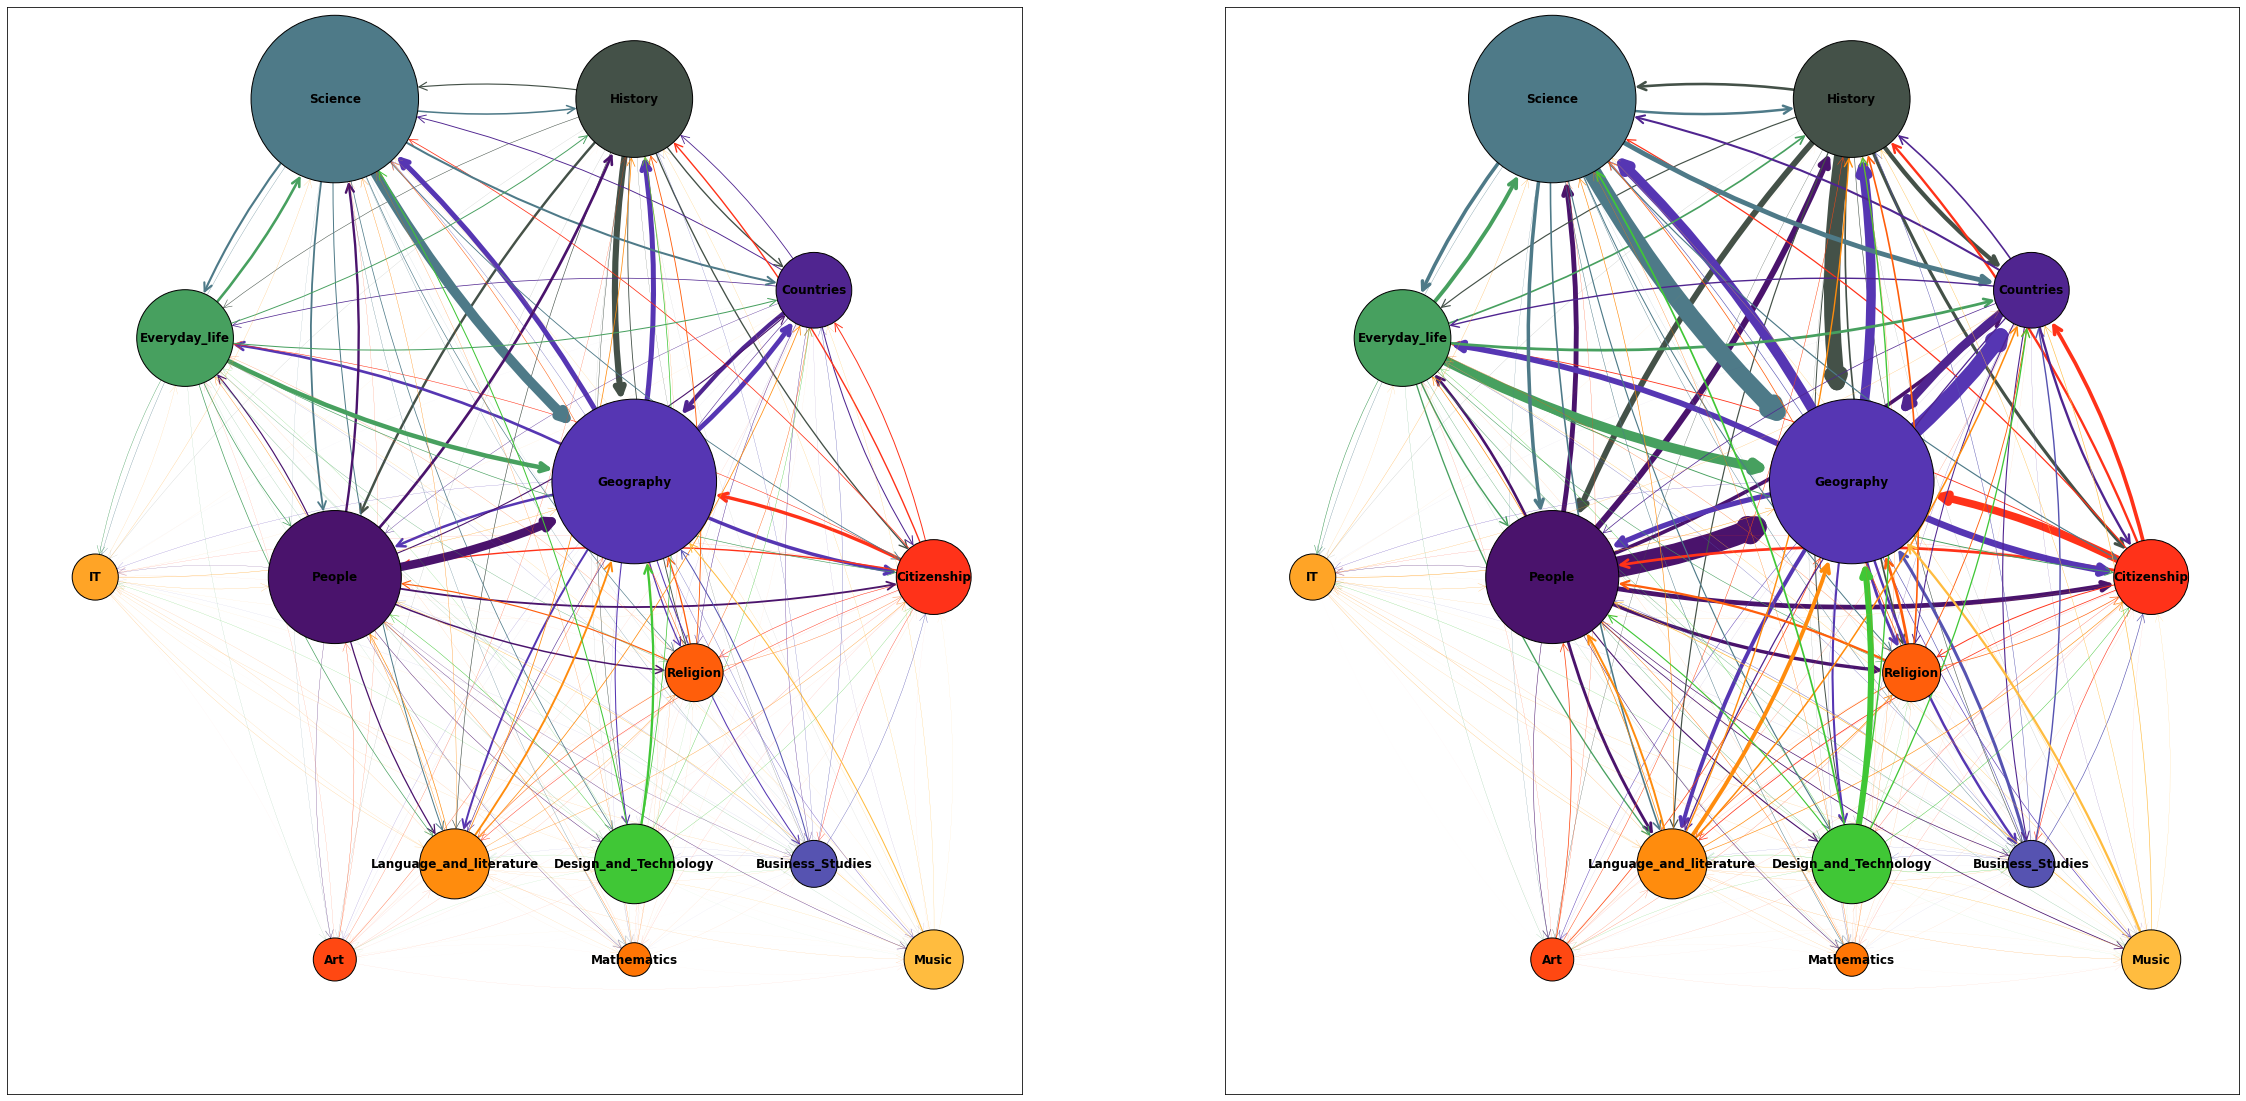

In [18]:
plt.figure(figsize=(40,20))
plt.subplot(121)
draw_graph(cs_graph, df_topics_cs)
plt.subplot(122)
draw_graph(truth_graph, df_topics_truth)
plt.show()

## Part 4 : Initial Analysis


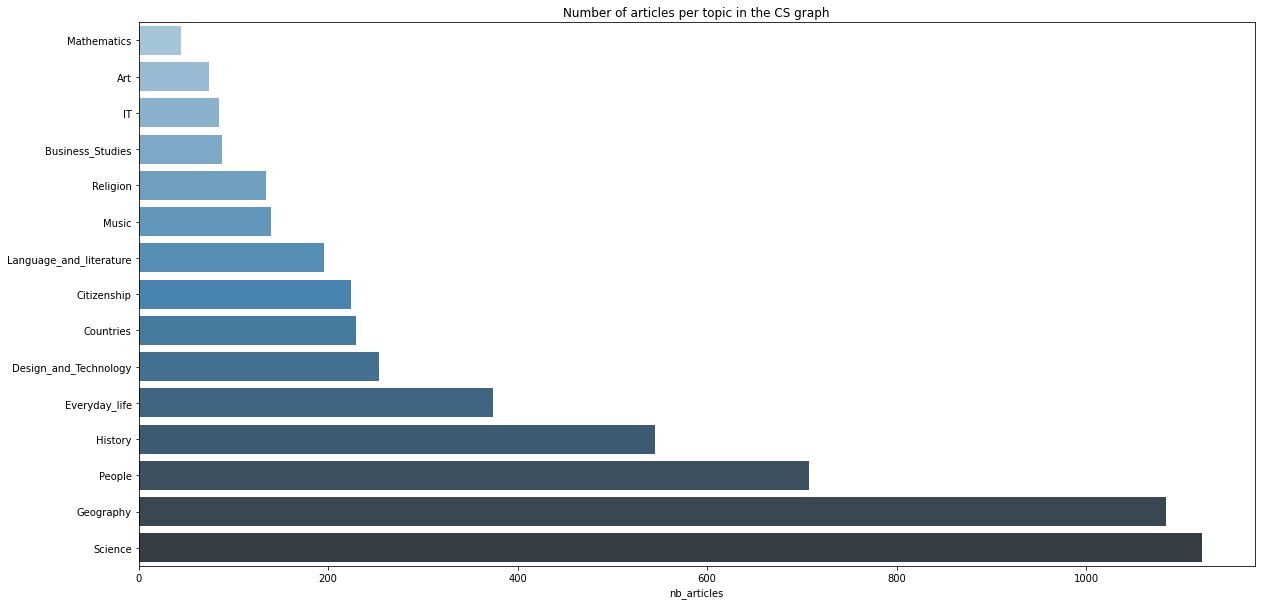

In [19]:
# plot the number of articles per topic with sns ordred by the number of articles
plt.figure(figsize=(20,10))
sns.barplot(x=df_topics_cs.nb_articles, y=df_topics_cs.index, data=df_topics_cs, order=df_topics_cs.sort_values(by=["nb_articles"], ascending=True).index, palette="Blues_d")
plt.title("Number of articles per topic in the CS graph")
plt.show()

We can see that the number of articles is nos uniformly distributed according to the Topics

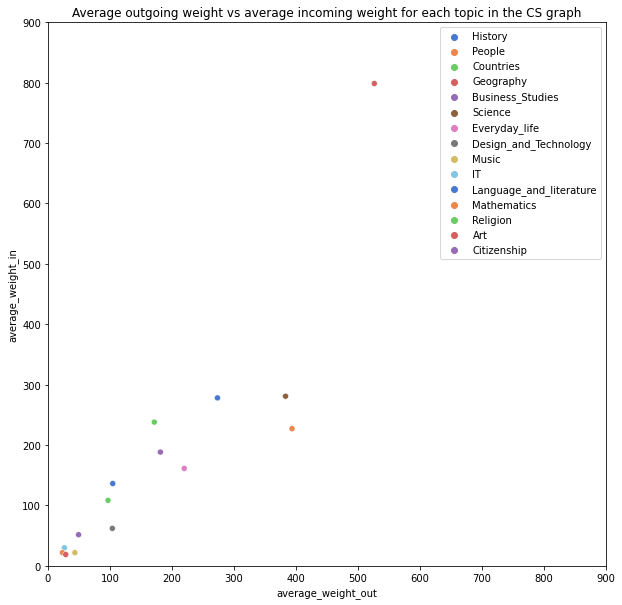

In [20]:
# plot the topics using average outgoing weight and average incoming weight
plt.figure(figsize=(10,10))
# x and y axis have the same scale
plt.xlim(0, 900)
plt.ylim(0, 900)

# multicolor palette sns
sns.set_palette("muted")

sns.scatterplot(x=df_topics_cs.average_weight_out, y=df_topics_cs.average_weight_in, data=df_topics_cs, hue=df_topics_cs.index, palette="muted")
plt.title("Average outgoing weight vs average incoming weight for each topic in the CS graph")
plt.show()
